In [1]:
############################################################################################
# IMPORTS
############################################################################################
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay


import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
#import tensorflow.keras as keras

from tensorflow.keras import layers
from tensorflow.keras import regularizers


from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Activation, Flatten

from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical



from IPython import display
from PIL import Image


import pathlib
import shutil
import tempfile
import concurrent

import pickle
import visualkeras

import json
import glob





print(tf.__version__)
print(tf.config.list_physical_devices())
############################################################################################

2025-01-05 21:26:01.789707: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736108761.819429  376416 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736108761.828201  376416 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-05 21:26:01.858600: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.18.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
############################################################################################
# 1. CONSTANTS - PATHS
############################################################################################

#DATA_FS251 = './data/iFood_2019'
DATA_FS251 = './data/food-101'
CLASSES_FILE_NAME = '/formated_annot/classes_formated.csv'

TRAIN_INFO = '/annot/train_info.csv'
VAL_INFO = '/annot/val_info.csv'
TEST_INFO = '/annot/test_info.csv'

TRAIN_PICS_PATH = './data/iFood_2019/train_set/'
TEST_PICS_PATH = './data/iFood_2019/test_set/'
VAL_PICS_PATH = './data/iFood_2019/val_set/'

MODELS = './models/'

SEED = 111

#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
gpu_dev = tf.config.experimental.list_physical_devices('GPU')
for itm in gpu_dev:
    tf.config.experimental.set_memory_growth(itm, True)


############################################################################################
# IMPORTING DATA
############################################################################################
df_classes = pd.read_csv(DATA_FS251 + CLASSES_FILE_NAME)
df_train = pd.read_csv(DATA_FS251 + TRAIN_INFO, names=['file_name', 'class_num'])
df_validate = pd.read_csv(DATA_FS251 + VAL_INFO, names=['file_name', 'class_num'])
df_test = pd.read_csv(DATA_FS251 + TEST_INFO, names=['file_name'])

df_train.head(3)

In [3]:
############################################################################################
# 2. CONSTANTS - MODEL
############################################################################################
training_history = dict()

#N_TRAIN = len(df_train.iloc[:, 0])
EPOCHS = 30
BATCH_SIZE = 128              # 8 fit into GPU RAM, 64 fit into system RAM
RESIZE_TO = (256, 256)
#STEPS_PER_EPOCH = N_TRAIN // BATCH_SIZE

############################################################################################
# FUNCTIONS, DEFFINITIONS
############################################################################################

class CRelu(tf.keras.Layer):
    def __init__(self, axis=-1, **kwargs):
        self.axis = axis 
        super(CRelu, self).__init__(**kwargs)

    def build(self, input_shape):
        super(CRelu, self).build(input_shape)

    def call(self, x):
        x = tf.nn.crelu(x, axis=self.axis)
        return x

    def compute_output_shape(self, input_shape):
        output_shape = list(input_shape)
        output_shape[-1] = output_shape[-1] * 2
        output_shape = tuple(output_shape)
        return output_shape

    def get_config(self, input_shape):
        config = {'axis': self.axis, }
        base_config = super(CReLU, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [4]:
############################################################################################
# import image files
############################################################################################

train_pics, val_pics = tf.keras.preprocessing.image_dataset_from_directory(
    './data/food-101/images/',
    labels='inferred',
#    label_mode='int',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
#    image_size=RESIZE_TO,
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset='both',
#    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format='channels_last',
    verbose=True
)
#test_pics = tf.keras.preprocessing.image_dataset_from_directory(
#    VAL_PICS_PATH,
#    labels='inferred',
#    label_mode='int',
#    label_mode='categorical',
#    class_names=None,
#    color_mode='rgb',
#    batch_size=BATCH_SIZE,
#    image_size=RESIZE_TO,
#    shuffle=True,
#    seed=SEED,
#    validation_split=None,
#    subset=None,
#    interpolation='bilinear',
#    follow_links=False,
#    crop_to_aspect_ratio=False,
#    pad_to_aspect_ratio=False,
#    data_format='channels_last',
#    verbose=True
#)
#true_test_pics = tf.keras.preprocessing.image_dataset_from_directory(
#    TEST_PICS_PATH,
#    labels=None,
#    label_mode=None,
#    class_names=None,
#    color_mode='rgb',
#    batch_size=BATCH_SIZE,
#    image_size=RESIZE_TO,
#    shuffle=True,
#    seed=SEED,
#    validation_split=None,
#    subset=None,
#    interpolation='bilinear',
#    follow_links=False,
#    crop_to_aspect_ratio=False,
#    pad_to_aspect_ratio=False,
#    data_format='channels_last',
#    verbose=True
#)

Found 101000 files belonging to 101 classes.
Using 80800 files for training.
Using 20200 files for validation.


I0000 00:00:1736108775.184253  376416 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5457 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1


In [5]:
train_pics.class_names
#val_pics.as_numpy_iterator().next()[0]
#val_pics.take(1)

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [6]:
############################################################################################
# DEFINING THE MODEL
############################################################################################
tf.keras.backend.clear_session()

core_model = tf.keras.applications.EfficientNetB0(include_top=False, input_shape=(240, 240, 3))
core_model.trainable = False
for layer in core_model.layers[-25:]:
    print(layer.output)
    print(layer.output)
#    layer.trainable = False

inputed = tf.keras.Input(shape=(256,256,3))
x = tf.keras.layers.Resizing(height = 240,width = 240,interpolation='bilinear',crop_to_aspect_ratio=False,pad_to_aspect_ratio=False,fill_mode='constant',fill_value=0.0)(inputed)
x = tf.keras.layers.RandomRotation(factor=0.3, seed=SEED)(x)
x = tf.keras.layers.RandomBrightness(factor=[-0.2, 0.2])(x)
x = tf.keras.layers.RandomContrast(factor=0.2)(x)
x = core_model(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.L2(0.01))(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01))(x)
x = tf.keras.layers.Dropout(0.5)(x) 
outputed = tf.keras.layers.Dense(units=101,activation='softmax',activity_regularizer=tf.keras.regularizers.L2(), name='Output_layer')(x)


model_supclass = tf.keras.Model(inputed,outputed)

model_supclass.summary()


<KerasTensor shape=(None, 1152), dtype=float32, sparse=False, name=keras_tensor_213>
<KerasTensor shape=(None, 1152), dtype=float32, sparse=False, name=keras_tensor_213>
<KerasTensor shape=(None, 1, 1, 1152), dtype=float32, sparse=False, name=keras_tensor_214>
<KerasTensor shape=(None, 1, 1, 1152), dtype=float32, sparse=False, name=keras_tensor_214>
<KerasTensor shape=(None, 1, 1, 48), dtype=float32, sparse=False, name=keras_tensor_215>
<KerasTensor shape=(None, 1, 1, 48), dtype=float32, sparse=False, name=keras_tensor_215>
<KerasTensor shape=(None, 1, 1, 1152), dtype=float32, sparse=False, name=keras_tensor_216>
<KerasTensor shape=(None, 1, 1, 1152), dtype=float32, sparse=False, name=keras_tensor_216>
<KerasTensor shape=(None, 8, 8, 1152), dtype=float32, sparse=False, name=keras_tensor_217>
<KerasTensor shape=(None, 8, 8, 1152), dtype=float32, sparse=False, name=keras_tensor_217>
<KerasTensor shape=(None, 8, 8, 192), dtype=float32, sparse=False, name=keras_tensor_218>
<KerasTensor sha

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing (Resizing)             │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 240, 240, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_brightness               │ (None, 240, 240, 3)    │             0 │
│ (RandomBrightness)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast                 │ (None, 240, 240, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 8, 8, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 8, 8, 128)      │     1,474,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_layer (Dense)            │ (None, 101)            │        25,957 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,583,240 (21.30 MB)

 Trainable params: 1,533,669 (5.85 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [7]:
############################################################################################
# COMPILING, FITTING 1
############################################################################################
model_supclass.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), #6.1 model, 6.5, 6.6
    #optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), #model 6.2, 6.3
    #optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), #model 6.4
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model_history_1 = model_supclass.fit(
    train_pics,
    validation_data=val_pics,
    epochs=5,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
)
############################################################################################
# COMPILING, FITTING 2
############################################################################################
core_model.trainable = True
for layer in core_model.layers[:-20]:
    layer.trainable = False
model_supclass.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model_history_2 = model_supclass.fit(
    train_pics,
    validation_data=val_pics,
    epochs=20,
    initial_epoch=5,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)



Epoch 1/5


E0000 00:00:1736108796.624341  376416 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1736108800.311472  376673 cuda_dnn.cc:529] Loaded cuDNN version 90600


632/632 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - accuracy: 0.2260 - loss: 4.7711

2025-01-05 21:32:29.355893: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:378] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


632/632 ━━━━━━━━━━━━━━━━━━━━ 453s 682ms/step - accuracy: 0.2261 - loss: 4.7697 - val_accuracy: 0.4891 - val_loss: 2.8939
Epoch 2/5
632/632 ━━━━━━━━━━━━━━━━━━━━ 422s 668ms/step - accuracy: 0.3725 - loss: 3.2291 - val_accuracy: 0.4914 - val_loss: 2.7609
Epoch 3/5
632/632 ━━━━━━━━━━━━━━━━━━━━ 422s 668ms/step - accuracy: 0.3970 - loss: 3.0696 - val_accuracy: 0.5114 - val_loss: 2.6842
Epoch 4/5
632/632 ━━━━━━━━━━━━━━━━━━━━ 423s 669ms/step - accuracy: 0.4042 - loss: 3.0276 - val_accuracy: 0.5175 - val_loss: 2.6322
Epoch 5/5
632/632 ━━━━━━━━━━━━━━━━━━━━ 421s 667ms/step - accuracy: 0.4164 - loss: 2.9699 - val_accuracy: 0.5140 - val_loss: 2.6132
Epoch 6/20


E0000 00:00:1736110939.439174  376416 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


632/632 ━━━━━━━━━━━━━━━━━━━━ 487s 742ms/step - accuracy: 0.4398 - loss: 2.8834 - val_accuracy: 0.5969 - val_loss: 2.2491
Epoch 7/20
632/632 ━━━━━━━━━━━━━━━━━━━━ 465s 736ms/step - accuracy: 0.5167 - loss: 2.4913 - val_accuracy: 0.6209 - val_loss: 2.1434
Epoch 8/20
632/632 ━━━━━━━━━━━━━━━━━━━━ 465s 736ms/step - accuracy: 0.5374 - loss: 2.3777 - val_accuracy: 0.6366 - val_loss: 2.0790
Epoch 9/20
632/632 ━━━━━━━━━━━━━━━━━━━━ 466s 737ms/step - accuracy: 0.5581 - loss: 2.3112 - val_accuracy: 0.6504 - val_loss: 2.0375
Epoch 10/20
632/632 ━━━━━━━━━━━━━━━━━━━━ 465s 736ms/step - accuracy: 0.5708 - loss: 2.2553 - val_accuracy: 0.6529 - val_loss: 2.0117
Epoch 11/20
632/632 ━━━━━━━━━━━━━━━━━━━━ 466s 737ms/step - accuracy: 0.5841 - loss: 2.2146 - val_accuracy: 0.6604 - val_loss: 1.9909
Epoch 12/20
632/632 ━━━━━━━━━━━━━━━━━━━━ 465s 736ms/step - accuracy: 0.5939 - loss: 2.1735 - val_accuracy: 0.6709 - val_loss: 1.9609
Epoch 13/20
632/632 ━━━━━━━━━━━━━━━━━━━━ 465s 737ms/step - accuracy: 0.6019 - loss: 

ValueError: DataFrame constructor not properly called!

In [ ]:
############################################################################################
# SAVING MODEL
############################################################################################
MODEL_NAME = 'Nadine_food-101-EfNetB0-A0.65-0.69-earlystop-E25of25-B128_softCat_v1.0'
os.makedirs( os.path.dirname(MODELS + 'test/' + MODEL_NAME + '/'), exist_ok=True)
model_supclass.save(MODELS + 'test/' + MODEL_NAME + '/'+ MODEL_NAME + ".keras")
#model_supclass_loaded = load_model(MODELS + MODEL_NAME + '/'+ MODEL_NAME + ".keras")
#model_supclass_loaded.summary()

model_history_df = pd.concat( [ pd.DataFrame(model_history_1.history, columns=['accuracy','loss','val_accuracy','val_loss']), pd.DataFrame(model_history_2.history, columns=['accuracy','loss','val_accuracy','val_loss'])], axis=0).reset_index(drop=True)

# with pickle
with open(MODELS + 'test/'+ MODEL_NAME + '/'+ MODEL_NAME + ".pckl", 'wb') as file_pi:
    pickle.dump(model_history_df, file_pi)
# history in csv format
hits_df = []
hits_df = pd.DataFrame(model_history_df)
hits_df.to_csv(MODELS + 'test/' + MODEL_NAME + '/'+ MODEL_NAME + '.hist_csv')


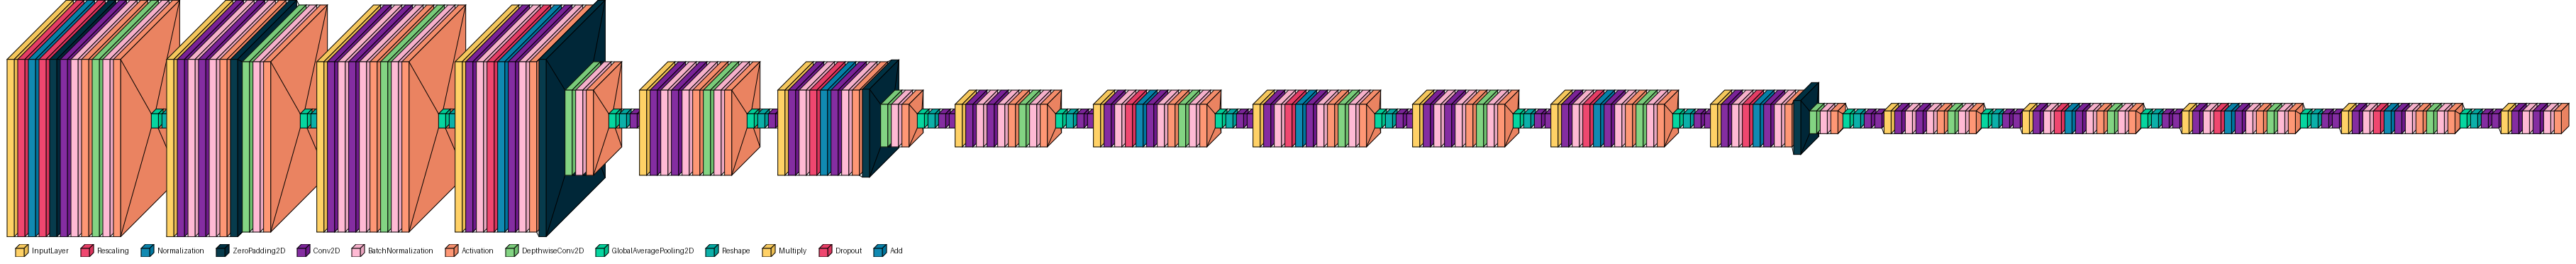

In [22]:
############################################################################################
# EVALUATION - MODEL STRUCTURE IMAGES
############################################################################################
tf.keras.utils.plot_model(
    model_supclass,
    to_file=MODELS + 'test/' + MODEL_NAME + '/'+ MODEL_NAME + '_model_diagram.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=False,
    rankdir='TB',
    expand_nested=False,
    dpi=200,
    show_layer_activations=True,
    show_trainable=True
)


visualkeras.layered_view(model_supclass,
                        to_file=MODELS + 'test/' + MODEL_NAME + '/'+ MODEL_NAME + '_layer_plot.png',
                        legend=True,
                        max_xy=250,
                        min_z = 1, 
                        max_z= 75,
                        scale_z = 5,
#                        color_map = color_map,
#                        show_nested = True,
                        spacing=50
#                        show_dimension=True
                        )
visualkeras.layered_view(core_model,
                        to_file=MODELS + 'test/' + MODEL_NAME + '/'+ MODEL_NAME + '_core_layer_plot.png',
                        legend=True,
                        max_xy=250,
                        min_z = 1, 
                        max_z= 10,
                        scale_z = 5,
#                        color_map = color_map,
#                        show_nested = True,
                        spacing=5
#                        show_dimension=True
                        )

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


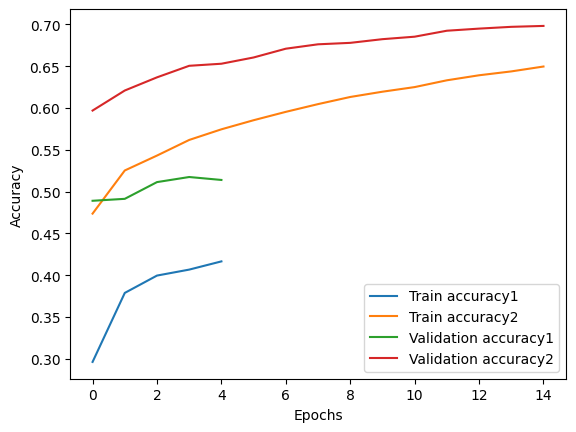

In [25]:
############################################################################################
# EVALUATION - ACCURACY
############################################################################################

plt.legend(bbox_to_anchor = [1, 1.02])
plt.plot(model_history_1.history['accuracy'],label='Train accuracy1')
plt.plot(model_history_2.history['accuracy'],label='Train accuracy2')
plt.plot(model_history_1.history['val_accuracy'],label='Validation accuracy1')
plt.plot(model_history_2.history['val_accuracy'],label='Validation accuracy2')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(MODELS + 'test/' + MODEL_NAME + '/'+ MODEL_NAME + '_ACCURACY.png')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


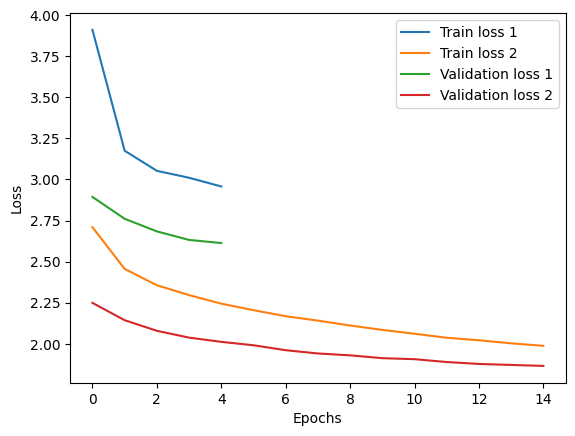

158/158 ━━━━━━━━━━━━━━━━━━━━ 80s 505ms/step - accuracy: 0.7018 - loss: 1.8597
[1.86519455909729, 0.6981188058853149] ['loss', 'compile_metrics']


In [27]:
############################################################################################
# EVALUATION - LOSS
############################################################################################

plt.legend(bbox_to_anchor = [1, 1.02])
plt.plot(model_history_1.history['loss'],label='Train loss 1')
plt.plot(model_history_2.history['loss'],label='Train loss 2')
plt.plot(model_history_1.history['val_loss'],label='Validation loss 1')
plt.plot(model_history_2.history['val_loss'],label='Validation loss 2')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig(MODELS + 'test/' + MODEL_NAME + '/'+ MODEL_NAME + '_LOSS.png')
plt.legend()
plt.show()

# Print out the score
score = model_supclass.evaluate(val_pics , batch_size=1, verbose=1)
print(score, model_supclass.metrics_names)

In [28]:
############################################################################################
# PREDICTION
############################################################################################

y_test_pred = np.array([])
y_test =  np.array([])
for x, y in val_pics:
        y_test_pred = np.concatenate([y_test_pred, np.argmax(model_supclass.predict(x, verbose=0), axis = -1)])
        y_test = np.concatenate([y_test, np.argmax(y.numpy(), axis=-1)])

2025-01-06 00:14:11.476883: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [29]:
#for x, y in val_pics:
#    print(y.shape)

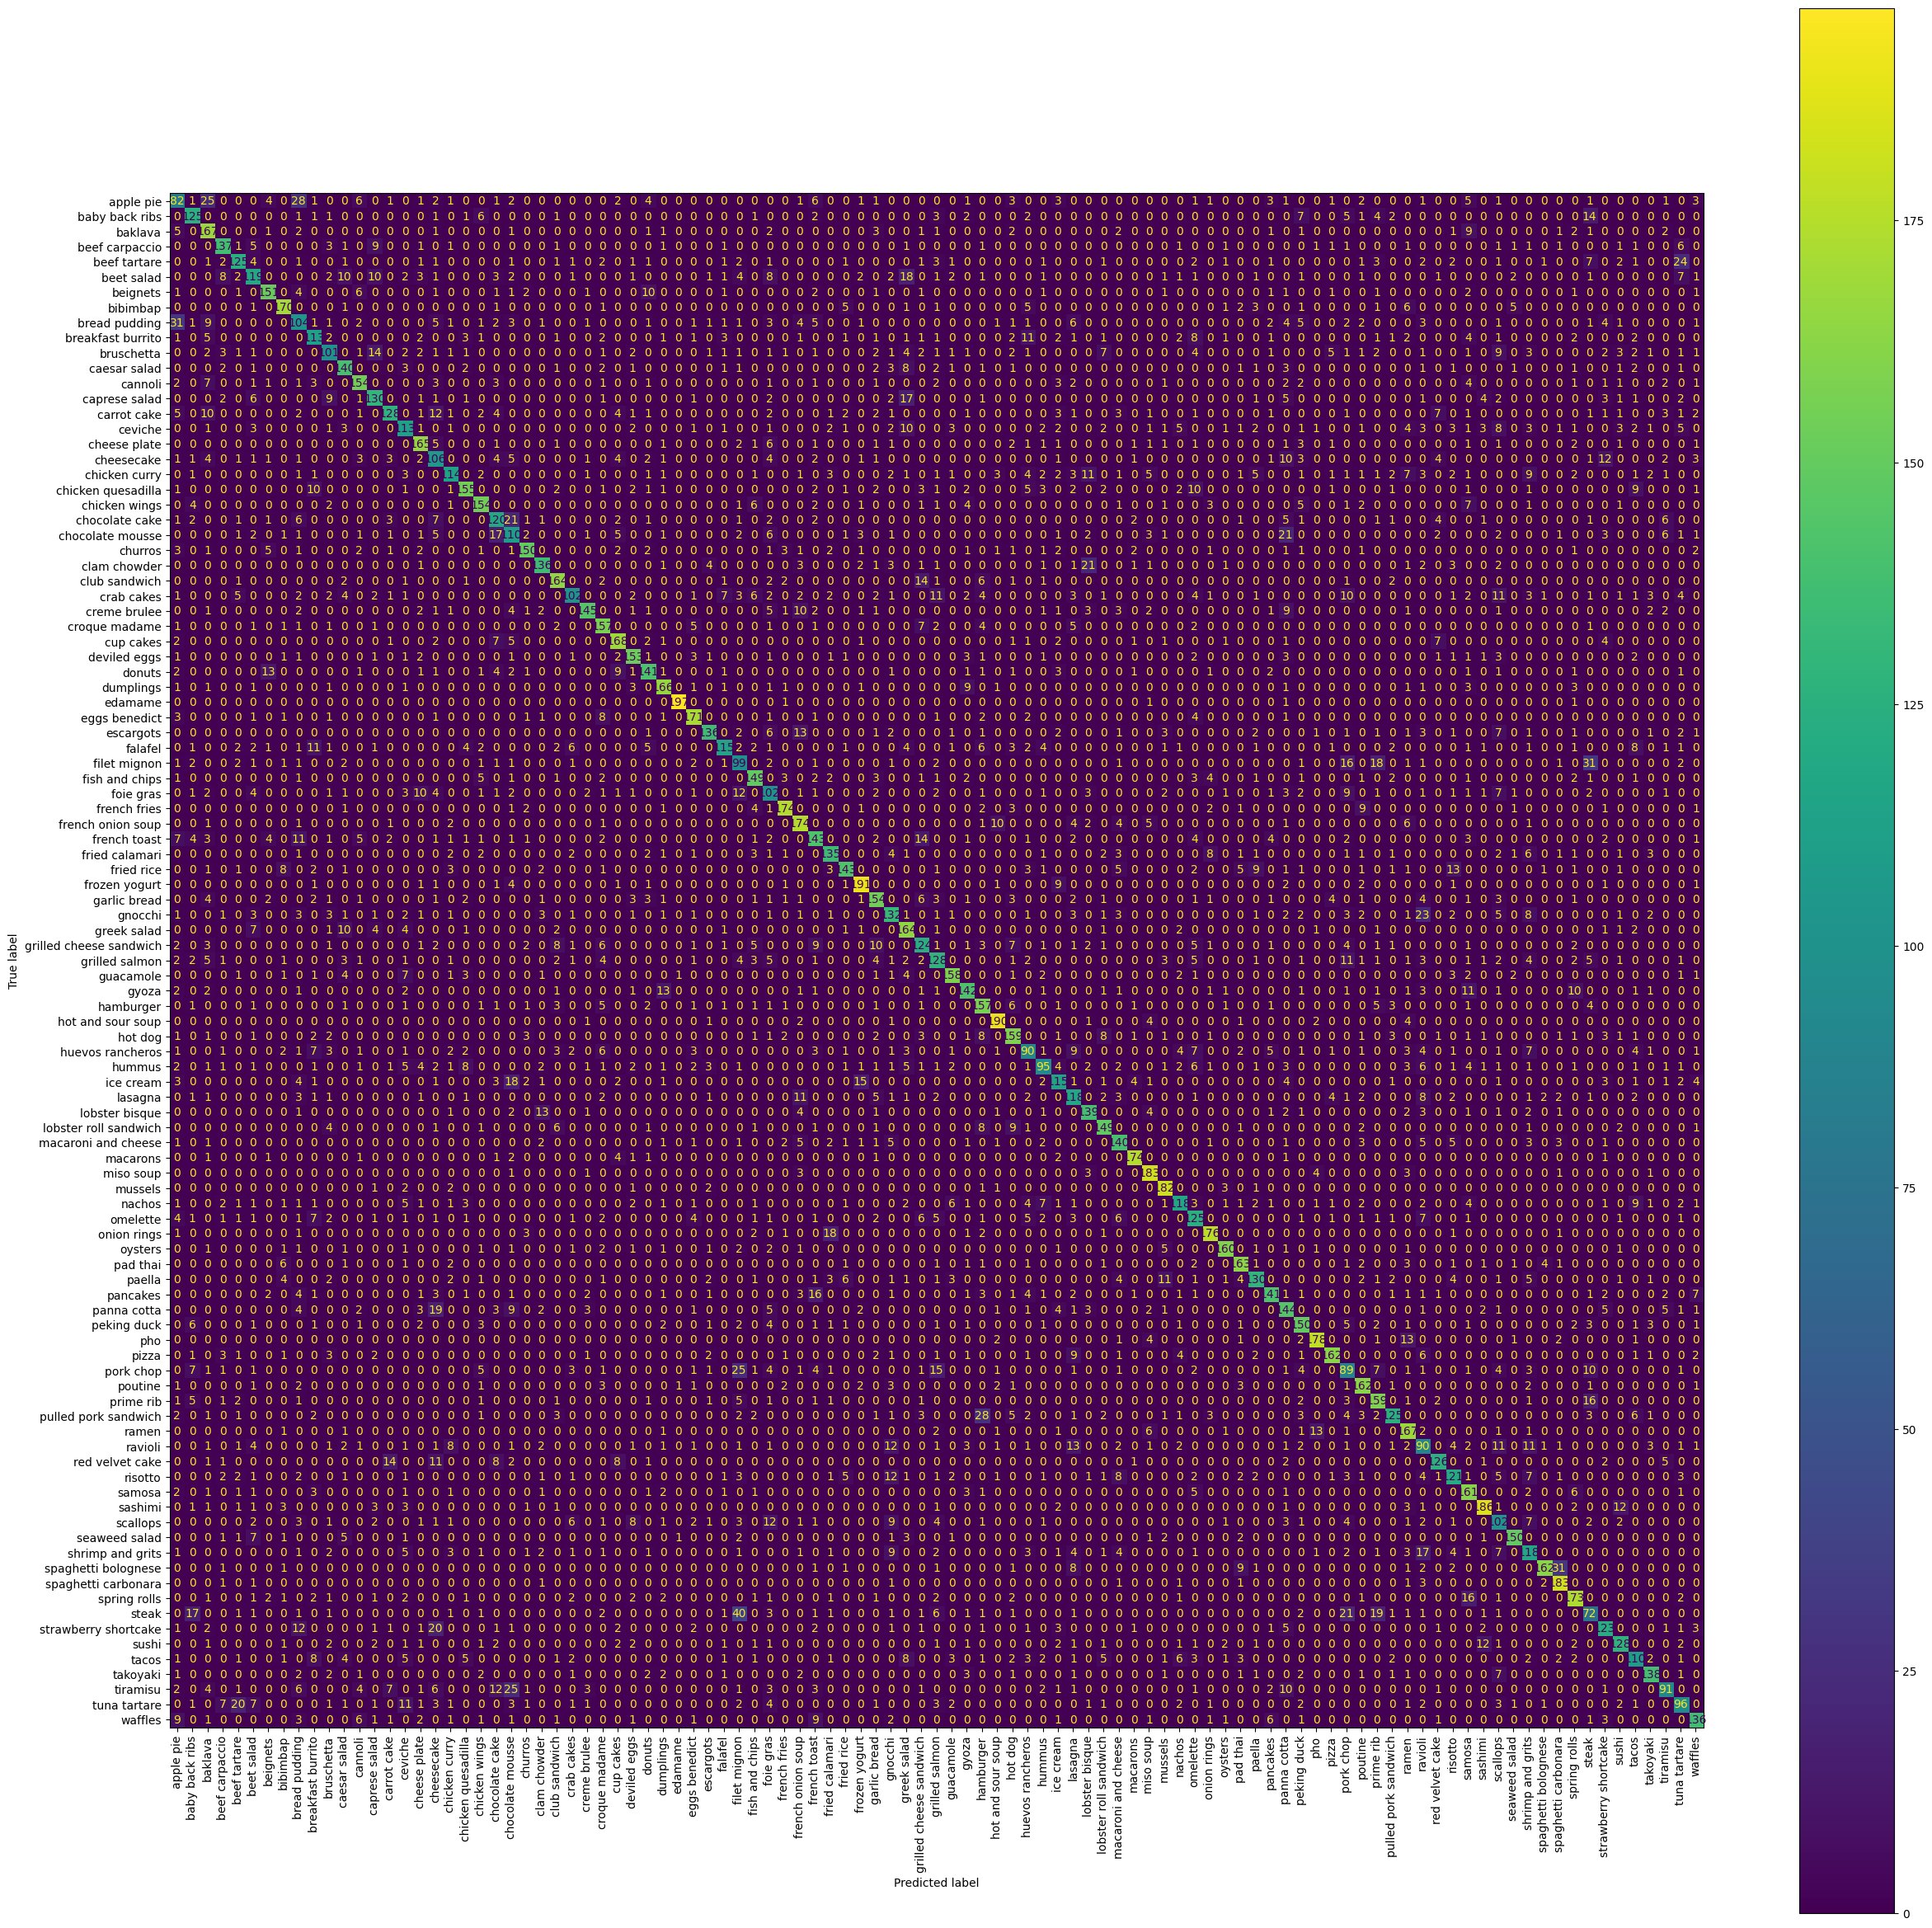

In [32]:
############################################################################################
# PREDICTION - CONFMATRIX
############################################################################################

from sklearn.metrics import ConfusionMatrixDisplay
plt.rcParams['figure.figsize'] = (30, 30)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true= y_test, y_pred=y_test_pred)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=np.unique(y_test))
labels = [str(val).lower().strip().replace('_',' ') for val in pd.DataFrame(val_pics.class_names, columns=['class'])['class'].tolist()]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.xticks(rotation=90)
plt.savefig(MODELS + 'test/' + MODEL_NAME + '/'+ MODEL_NAME + '_CONFMAT.png')
plt.show()






In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in val_pics.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(str( labels[i].numpy().astype(int) ) + str(np.argmax(model_supclass.predict(images[i], verbose=0), axis = -1))  )
        plt.axis("off")
        

In [ ]:
#plt.imshow(images[0].numpy().astype("uint8"))
#plt.show()
